## MuSCAT3 TFOP template: optimization 
RECENT CHANGES:
* added of normalized flux plot for each selected_cID
* compute rms to all cID combination and aperture radius combination
* BJD_TDB conversion using barycorrpy

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
import astropy.units as u
from astropy.time import Time
from astropy.coordinates import SkyCoord
from astroplan import Observer

import sys
sys.path.insert(0, "/ut3/muscat/src/AFPy")
import LC_funcs as lc

In [34]:
## parameter setup
#===========

bands = ['g', 'r', 'i', 'z']
date = '220630'

target='TOI-5671'
toi='5671' # TOI number
#tic='TIC199444169'
plnum='01'

tID=8             # target ID
## aperture radius range
r1=8              # initial radius in pix
r2=20                # final radius in pix
dr=2                 # step size in pix

initial='jd' #initial of your name (or narita-san's name?)
#===========

In [42]:
from urllib.request import urlopen
import json

target = f"TOI-{toi}.01"
url = f"https://exofop.ipac.caltech.edu/tess/target.php?id={target}&json"
response = urlopen(url)
data_json = json.loads(response.read())
ra  = float(data_json['coordinates']['ra'])      # target coord in deg
dec = float(data_json['coordinates']['dec'])       # target coord in deg
ra, dec

(211.009219627329, 38.6183309836516)

In [43]:
inst='muscat3'
nband = len(bands)
ap = np.arange(r1, r2+dr, dr)
nap=len(ap)
print('available aperture radii: ', ap)

available aperture radii:  [ 8 10 12 14 16 18 20]


In [44]:
from itertools import combinations

nstars = 10
#get all cID from 1 to nstars excluding tID
selected_cIDs = [str(i) for i in range(1, nstars+1) if i!=tID]
#or specify each cID below
# selected_cIDs = ['2','3','4','5','7', '8','9','10']
assert str(tID) not in selected_cIDs

cIDs = []
for i in range(len(selected_cIDs)):
    cs = list(combinations(selected_cIDs,i+1))
    flatlist=[''.join(j) for j in cs]
    cIDs.append(flatlist)
cIDs = [item for sublist in cIDs for item in sublist]
len(cIDs)

511

In [45]:
method='mapping'

phot_dir = f'/home/muscat/reduction_afphot/muscat3/{date}/{target}/{method}'

phot=[]
for i in range(nband):
    phot.append([])
    
    for j in range(len(cIDs)):
        infile = f"{phot_dir}/lcf_{inst}_{bands[i]}_{target}_{date}_t{tID}_c{cIDs[j]}_r{str(r1)}-{str(r2)}.csv"
        phot[i].append(Table.read(infile))

In [46]:
#nband, ncID, ndata
len(phot), len(phot[0]), len(phot[0][0])

(4, 511, 121)

## show sample quick look

In [47]:
i=0
j=0 # cIDs
k=0 # ap_rad

/ut3/jerome/miniconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in true_divide
/ut3/jerome/miniconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in true_divide


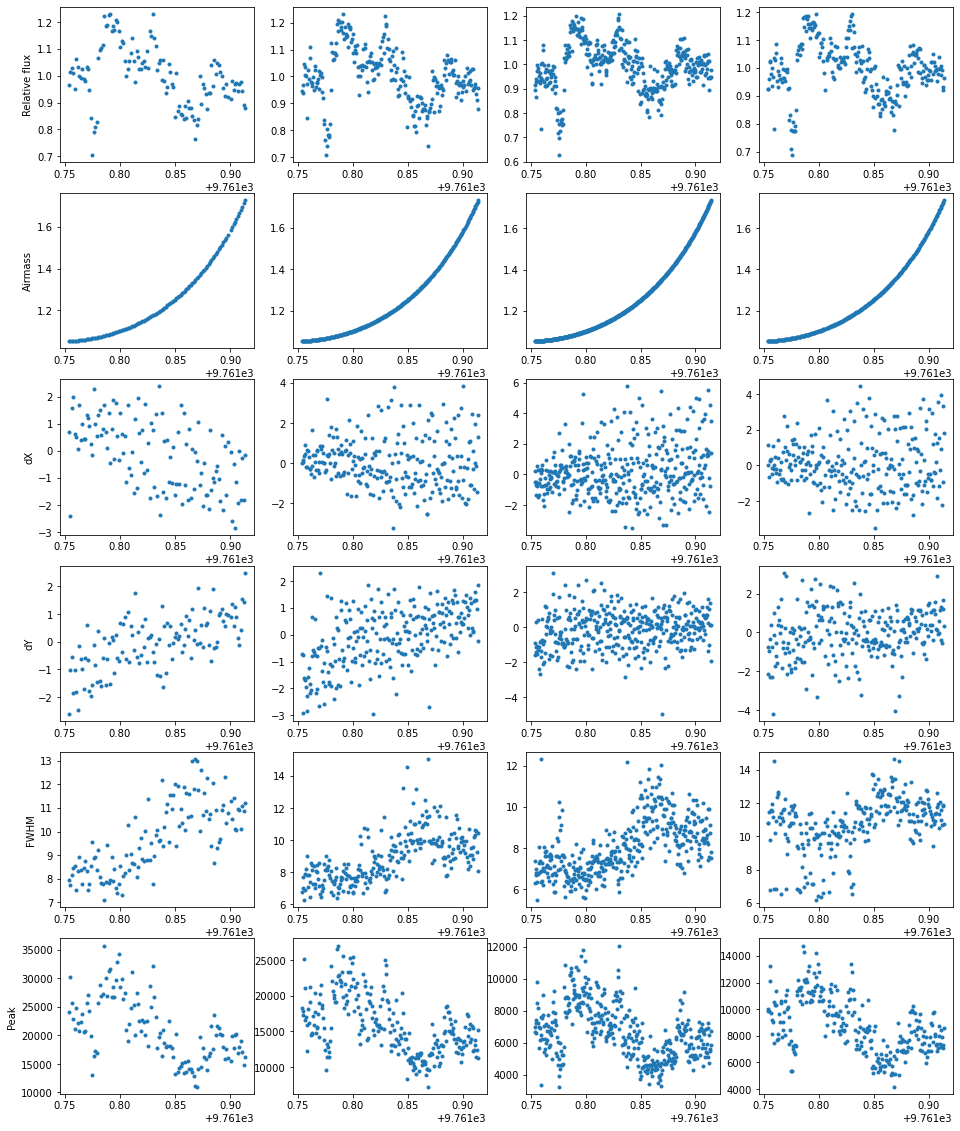

In [48]:
peak_cut = 120_000
amass_cut = 2.5
fwhm_cut = [30,30,30,30]
dx_min = -4
dx_max = 5
dy_min = -4
dy_max = 5
#raw_cut = np.array((0.85, 0.87, 0.90, 0.90))
raw_cut = np.array((0., 0., 0., 0.))

jd_cut_min = np.min(phot[i][j]['GJD-2450000'])
jd_cut_max = np.max(phot[i][j]['GJD-2450000'])
#jd_cut_min = 9050.415
#jd_exclude_min = 9032.514
#jd_exclude_max = 9032.5375

fcomp_key = 'flux_comp(r=' + '{0:.1f})'.format(ap[k])
f_key = 'flux(r=' + '{0:.1f})'.format(ap[k])
e_key = 'flux(r=' + '{0:.1f})'.format(ap[k])

fig, ax = plt.subplots(6,4, figsize=(16,20))
for i in range(nband):
    mask_t= (phot[i][j]['GJD-2450000'] > 0)

    raw_norm = phot[i][j][fcomp_key]/phot[i][j]['exptime'] /\
               np.median(phot[i][j][fcomp_key][mask_t]/phot[i][j]['exptime'][mask_t])
    
    mask = (raw_norm > raw_cut[i])\
            & (phot[i][j]['airmass'] < amass_cut)\
#            & (phot[i][j]['fwhm(pix)'] < fwhm_cut[i])\
#            & (phot[i][j]['dx(pix)'] < dx_max)\
#            & (phot[i][j]['dx(pix)'] > dx_min)\
#            & (phot[i][j]['dy(pix)'] < dy_max)\
#            & (phot[i][j]['dy(pix)'] > dy_min)\
#            & (phot[i][j]['peak(ADU)']<peak_cut)\
#            & (phot[i][j]['GJD-2450000'] > jd_cut_min) & (phot[i][j]['GJD-2450000'] < jd_cut_max)\
            
    
    ax[0][i].plot(phot[i][j]['GJD-2450000'][mask],raw_norm[mask],'.')
    ax[1][i].plot(phot[i][j]['GJD-2450000'][mask],phot[i][j]['airmass'][mask],'.')
    ax[2][i].plot(phot[i][j]['GJD-2450000'][mask],phot[i][j]['dx(pix)'][mask],'.')
    ax[3][i].plot(phot[i][j]['GJD-2450000'][mask],phot[i][j]['dy(pix)'][mask],'.')
    ax[4][i].plot(phot[i][j]['GJD-2450000'][mask],phot[i][j]['fwhm(pix)'][mask],'.')
    ax[5][i].plot(phot[i][j]['GJD-2450000'][mask],phot[i][j]['peak(ADU)'][mask],'.')
    ax[0][0].set_ylabel('Relative flux')
    ax[1][0].set_ylabel('Airmass')
    ax[2][0].set_ylabel('dX')
    ax[3][0].set_ylabel('dY')
    ax[4][0].set_ylabel('FWHM')
    ax[5][0].set_ylabel('Peak')
    
    
plt.show()

## show normalized flux for each selected_cID and radius

In [49]:
#============
n = 3 #band number
#============

In [50]:
%%time

from tqdm.notebook import tqdm

sigma_cut = 3
order = 3

index = []

print('band, cIDs, apID, ndata_init, ndata_final')
for i in tqdm(range(nband)):
    
    index.append([]) 
    for j in range(len(cIDs)):
        
        index[i].append([])
        for k in range(len(ap)):
            
            
            fcomp_key = 'flux_comp(r=' + '{0:.1f})'.format(ap[k])
            f_key = 'flux(r=' + '{0:.1f})'.format(ap[k])
            e_key = 'flux(r=' + '{0:.1f})'.format(ap[k])
            mask_t= (phot[i][j]['GJD-2450000'] > 0)

            raw_norm = (phot[i][j][fcomp_key]/phot[i][j]['exptime']) /\
                        np.median(phot[i][j][fcomp_key][mask_t]/phot[i][j]['exptime'][mask_t])
            mask = (raw_norm > raw_cut[i])\
                & (phot[i][j]['airmass'] < amass_cut)\
#                & (phot[i][j]['fwhm(pix)'] < fwhm_cut[i])\
#                & (phot[i][j]['dx(pix)'] < dx_max)\
#                & (phot[i][j]['dx(pix)'] > dx_min)\
#                & (phot[i][j]['dy(pix)'] < dy_max)\
#                & (phot[i][j]['dy(pix)'] > dy_min)\
            
            fcomp_median = np.median(phot[i][j][fcomp_key]/phot[i][j]['exptime'])
            ye = np.sqrt(phot[i][j][fcomp_key][mask])/phot[i][j]['exptime'][mask]/fcomp_median

            if(len(ye)>0):
                p, tcut, ycut, yecut\
                    = lc.outcut_polyfit(phot[i][j]['GJD-2450000'][mask], raw_norm[mask], ye, order, sigma_cut)
                index[i][j].append(np.isin(phot[i][j]['GJD-2450000'], tcut))
#                 print('{0}, {1}, {2}, {3}, {4}'.format(i, j, k, len(phot[i][j]), len(tcut)))
            
            else:
                index[i][j].append(np.isin(phot[i][j]['GJD-2450000'], np.empty(0)))

band, cIDs, apID, ndata_init, ndata_final


  0%|          | 0/4 [00:00<?, ?it/s]

/ut3/jerome/miniconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide
/ut3/jerome/miniconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in true_divide


CPU times: user 2h 55min 41s, sys: 8.2 s, total: 2h 55min 49s
Wall time: 2h 55min 43s


In [51]:
rms=[]
rms_min=[]
rms_argmin=[]

min_rms=[]
min_arg=[]
min_cIDs=[]
min_ap=[]

for i in range(nband):
    
    print('\n## ccd={} ##'.format(i))
    print('arg, cIDs, ap, rms')
    
    rms.append([])
    min_rms.append(np.inf)
    min_arg.append(0)
    min_cIDs.append(0)
    min_ap.append(0)
    
    for j in range(len(cIDs)):
    
        rms[i].append([])
        for k in range(len(ap)):
    
            f_key = 'flux(r=' + '{0:.1f})'.format(ap[k])
            flux_tmp0 = phot[i][j][f_key][index[i][j][k]]
            flux_tmp1 = flux_tmp0[1:]
            flux_tmp2 = flux_tmp0[:-1]
            diff = flux_tmp1-flux_tmp2
    
            if(np.std(diff)>0):
                rms[i][j].append(np.std(diff))
            else:
                rms[i][j].append(np.inf)
                
            arg=j*len(ap)+k
            print('{0}, {1}, {2}, {3:.5f}'.format(arg, j, k, rms[i][j][k]))
            
            if(rms[i][j][k]<min_rms[i]):
                min_rms[i]=rms[i][j][k]
                min_arg[i]=arg
                min_cIDs[i]=j
                min_ap[i]=k

print('')
print('Best parameters:')
print('ccd,  arg, cIDs,  ap,  rms')
for i in range(nband):
    print('{0},  {1},  {2},  {3},  {4:.5f}'.format(i,min_arg[i], min_cIDs[i], min_ap[i], min_rms[i]))


## ccd=0 ##
arg, cIDs, ap, rms
0, 0, 0, 0.01500
1, 0, 1, 0.01516
2, 0, 2, 0.01706
3, 0, 3, 0.01887
4, 0, 4, 0.02267
5, 0, 5, 0.02783
6, 0, 6, 0.03531
7, 1, 0, 0.01620
8, 1, 1, 0.01610
9, 1, 2, 0.01791
10, 1, 3, 0.01922
11, 1, 4, 0.02326
12, 1, 5, 0.02849
13, 1, 6, 0.03620
14, 2, 0, 0.01739
15, 2, 1, 0.01732
16, 2, 2, 0.01857
17, 2, 3, 0.01980
18, 2, 4, 0.02362
19, 2, 5, 0.02864
20, 2, 6, 0.04182
21, 3, 0, 0.01587
22, 3, 1, 0.01614
23, 3, 2, 0.01733
24, 3, 3, 0.01872
25, 3, 4, 0.02269
26, 3, 5, 0.02775
27, 3, 6, 0.04190
28, 4, 0, 0.01599
29, 4, 1, 0.01651
30, 4, 2, 0.01765
31, 4, 3, 0.01900
32, 4, 4, 0.02306
33, 4, 5, 0.02863
34, 4, 6, 0.03716
35, 5, 0, 0.01484
36, 5, 1, 0.01478
37, 5, 2, 0.01639
38, 5, 3, 0.01783
39, 5, 4, 0.02132
40, 5, 5, 0.02597
41, 5, 6, 0.03311
42, 6, 0, 0.01700
43, 6, 1, 0.01755
44, 6, 2, 0.01916
45, 6, 3, 0.02017
46, 6, 4, 0.02374
47, 6, 5, 0.02889
48, 6, 6, 0.04182
49, 7, 0, 0.01682
50, 7, 1, 0.01718
51, 7, 2, 0.01893
52, 7, 3, 0.02135
53, 7, 4, 0.02459
54, 7,

## show rms for each cID and aperture

In [52]:
import pandas as pd

def highlight_min(s, color='yellow'):
    '''
    highlight the maximum in a Series yellow.
    '''
    is_min = s == s.min()
    return [f'background-color: {color}' if v else '' for v in is_min]

cIDs_best = []
ap_best = []

df_rms = {}
for i in range(nband):
    band = bands[i]
    
    #create a dataframe
    df = pd.DataFrame(rms[i], columns=[f'r={i}' for i in ap], dtype=float)
    # save df in dict
    df_rms[band] = df
    
    idx = np.unravel_index(np.argmin(df), shape=df.shape)
    
    print(f"{band}-band: {idx}")
    
    cIDs_best.append(idx[0])
    ap_best.append(idx[1])

g-band: (40, 0)
r-band: (5, 0)
i-band: (246, 0)
z-band: (114, 2)


In [53]:
# show rms 
band = 'z'
df = df_rms[band]
df2 = df.loc[df.idxmin().unique()]
df2.index = [cIDs[i] for i in df2.index]
df2.index.name = 'cIDs'
#min rms in ppm
df2.\
    applymap(lambda x: x*1e3).\
    style.\
    apply(highlight_min, color='mediumseagreen', axis=0)

,r=8,r=10,r=12,r=14,r=16,r=18,r=20
cIDs,,,,,,,
6,6.691047,6.022161,6.516737,8.823447,13.891208,26.287541,56.197235
469,20.660204,9.434227,6.015299,7.208277,11.269045,21.462855,46.290077
46,23.319497,10.406548,6.243320,7.000565,11.147200,21.518971,46.902633
24,15.427617,11.441876,8.418161,7.711421,9.442450,14.564352,27.761754
4,101.194911,39.562364,19.826807,14.519766,11.580780,14.825926,27.186654


In [54]:
selected_cIDs

['1', '2', '3', '4', '5', '6', '7', '9', '10']

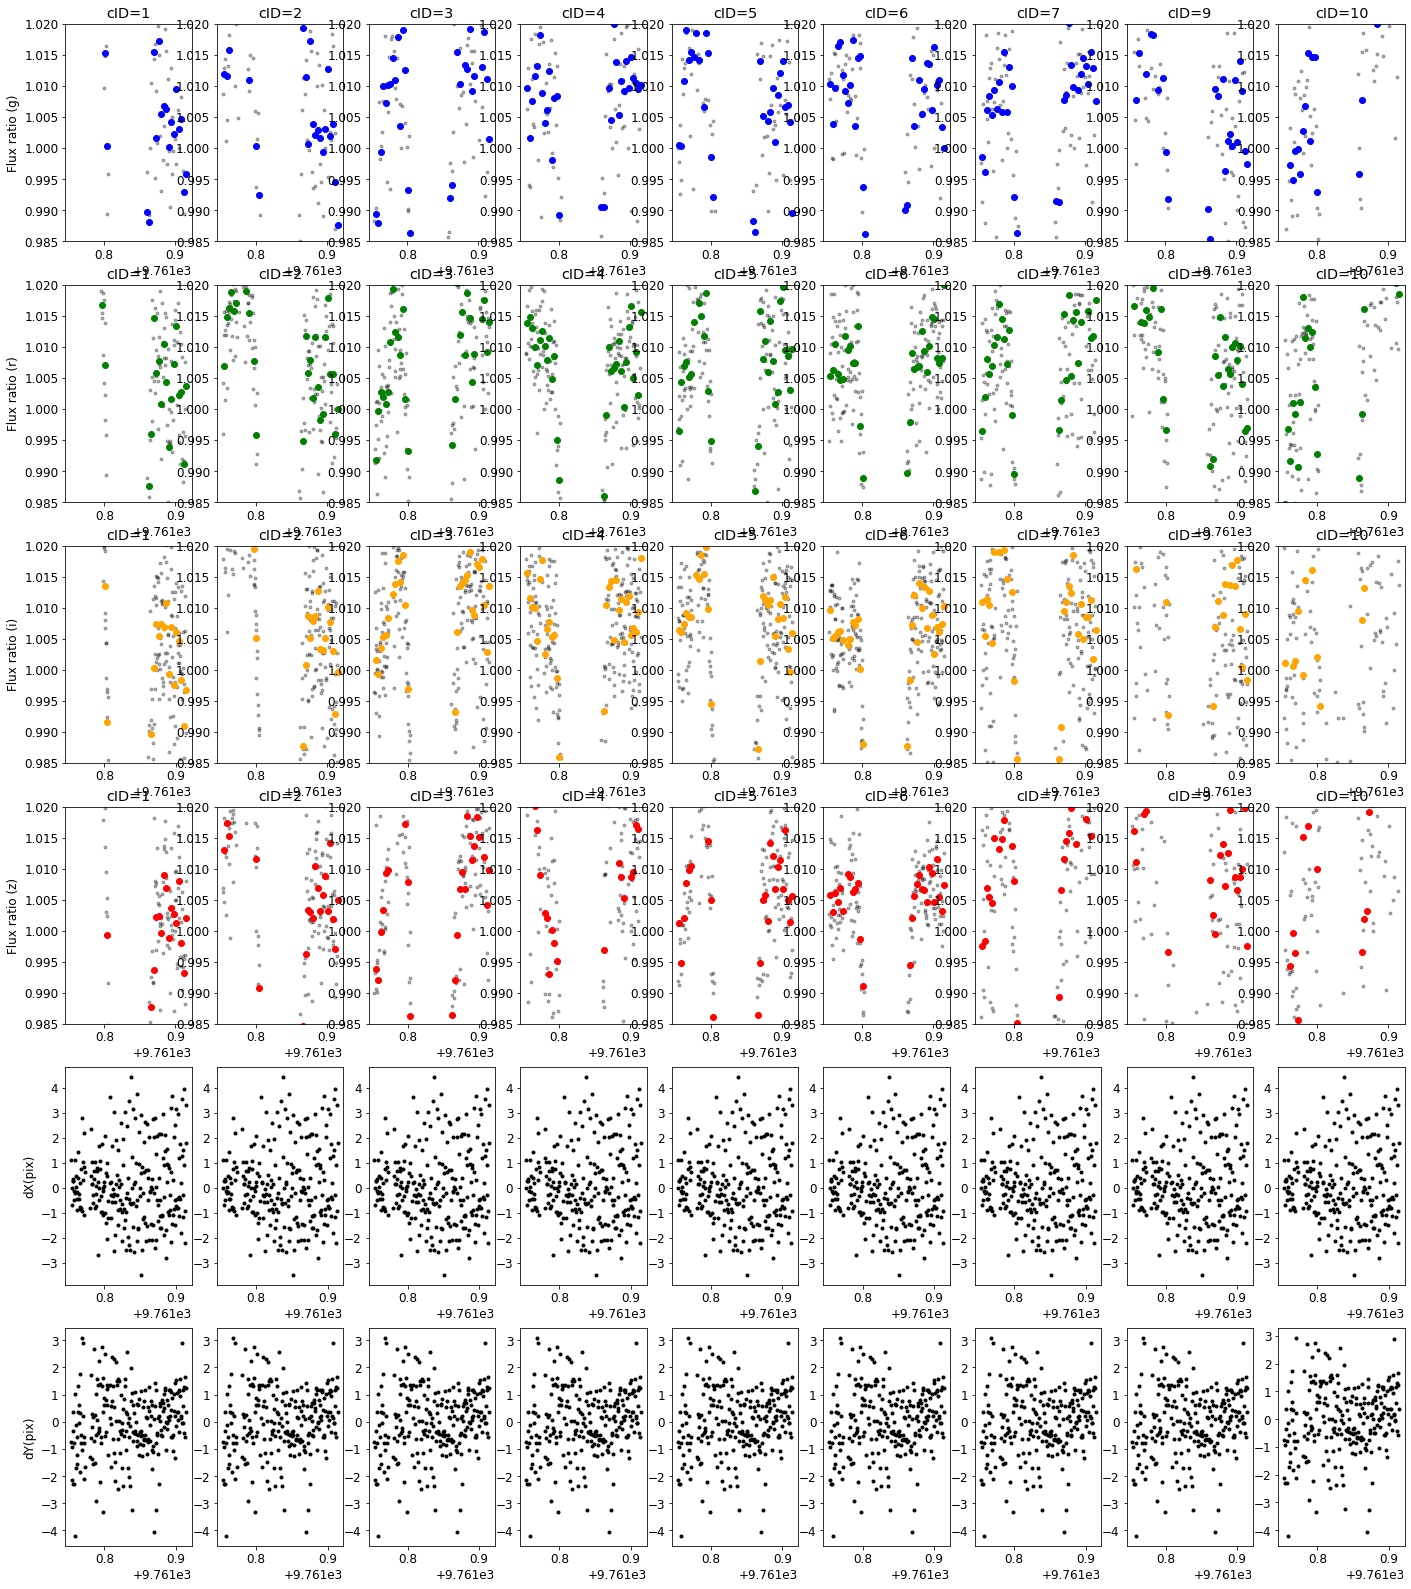

In [55]:
binsize = 300/86400.
tbin=[]
ybin=[]
yebin=[]

colors=['blue','green','orange','red']
#bands=['(g)','(r)','(i)','(z_s)']

plt.figure(figsize=(24,28))
plt.rcParams['font.size']=12
tx=8980.64
ty=1.015
nccd=4
for i in range(nccd):
    for j in range(len(selected_cIDs)):
    
        f_key = 'flux(r=' + '{0:.1f})'.format(ap[ap_best[i]])
        e_key = 'flux(r=' + '{0:.1f})'.format(ap[ap_best[i]])
        t0 = np.min(phot[i][j]['GJD-2450000'][index[i][j][ap_best[i]]])
        tbin_tmp, ybin_tmp, yebin_tmp=\
            lc.binning_equal_interval(phot[i][j]['GJD-2450000'][index[i][j][ap_best[i]]],\
                                  phot[i][j][f_key][index[i][j][ap_best[i]]],\
                                  phot[i][j][e_key][index[i][j][ap_best[i]]], binsize, t0)
    
        tbin.append(tbin_tmp)
        ybin.append(ybin_tmp)
        yebin.append(yebin_tmp)
        plt.subplot(6,len(selected_cIDs), j + i*len(selected_cIDs) +1)
        plt.title(f'cID={selected_cIDs[j]}')
        
        plt.plot(phot[i][j]['GJD-2450000'][index[i][j][ap_best[i]]],\
                 phot[i][j][f_key][index[i][j][ap_best[i]]],'.k',alpha=0.3)
        plt.ylim(0.985,1.02)
        plt.plot(tbin_tmp, ybin_tmp,'o',color=colors[i])
#        plt.text(tx,ty,'compID='+cIDs[j])
        if j == 0:
            plt.ylabel('Flux ratio ('+bands[i]+')')
            
for j in range(len(selected_cIDs)):
    plt.subplot(6,len(selected_cIDs), j + nccd*len(selected_cIDs) +1)
    plt.plot(phot[i][j]['GJD-2450000'][index[i][j][ap_best[i]]],\
                 phot[i][j]['dx(pix)'][index[i][j][ap_best[i]]],'.k')
    if j ==0:
        plt.ylabel('dX(pix)')
    plt.subplot(6,len(selected_cIDs), j + 5*len(selected_cIDs) +1)
    plt.plot(phot[i][j]['GJD-2450000'][index[i][j][ap_best[i]]],\
                 phot[i][j]['dy(pix)'][index[i][j][ap_best[i]]],'.k')
    if j ==0:
        plt.ylabel('dY(pix)')

#plt.savefig('phot_TOI1410_M2_200510.png')
plt.show()

best cids = (2456, 3456, 2, 235)


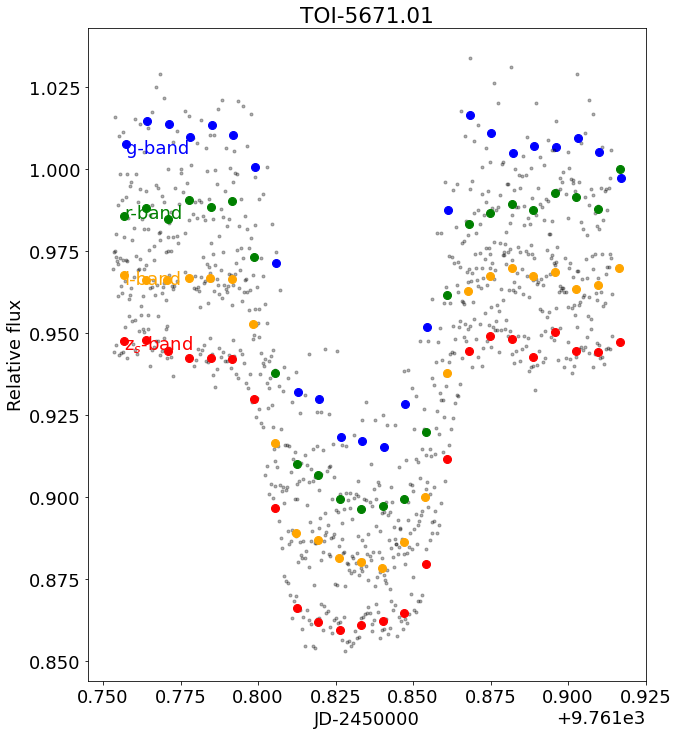

In [57]:
binsize = 600/86400.
tbin=[]
ybin=[]
yebin=[]
band_names = ['g-band','r-band','i-band','z$_s$-band']

offset=np.array((0,-0.02,-0.04,-0.06))

plt.figure(figsize=(10,12))
plt.rcParams['font.size']=18
for i in range(nband):
    
    f_key = 'flux(r=' + '{0:.1f})'.format(ap[ap_best[i]])
    e_key = 'flux(r=' + '{0:.1f})'.format(ap[ap_best[i]])
    t0 = np.min(phot[i][cIDs_best[i]]['GJD-2450000'][index[i][cIDs_best[i]][ap_best[i]]])
    tbin_tmp, ybin_tmp, yebin_tmp=\
        lc.binning_equal_interval(phot[i][cIDs_best[i]]['GJD-2450000'][index[i][cIDs_best[i]][ap_best[i]]],\
                                  phot[i][cIDs_best[i]][f_key][index[i][cIDs_best[i]][ap_best[i]]],\
                                  phot[i][cIDs_best[i]][e_key][index[i][cIDs_best[i]][ap_best[i]]], binsize, t0)
    
    tbin.append(tbin_tmp)
    ybin.append(ybin_tmp)
    yebin.append(yebin_tmp)
    
    plt.plot(phot[i][cIDs_best[i]]['GJD-2450000'][index[i][cIDs_best[i]][ap_best[i]]],\
             phot[i][cIDs_best[i]][f_key][index[i][cIDs_best[i]][ap_best[i]]]+offset[i],'.k',alpha=0.3)
#    plt.ylim(0.985,1.015)
    plt.plot(tbin[i], ybin[i]+offset[i],'o',color=colors[i], markersize=8)
    tx=tbin[i][0]
    ty=1.005+offset[i]
    plt.text(tx,ty,band_names[i],color=colors[i])
#plt.xlabel('')
plt.title(target)
plt.xlabel('JD-2450000')
plt.ylabel('Relative flux')
outfile = '{0}_{1}.png'.format(target,date)
plt.savefig(outfile,bbox_inches='tight',pad_inches=0.1)
plt.show()

## convert UTC TO TDB
* two methods available using barycorrpy package or astropy's `light_travel_time` package

In [58]:
obs_site = Observer.at_site("Haleakala")
objcoord = SkyCoord(ra=ra, dec=dec, unit=("deg","deg"))

use_barycorrpy = True

bjd = []
for i in range(nband):
    jd = Time(np.array(phot[i][cIDs_best[i]]['GJD-2450000'][index[i][cIDs_best[i]][ap_best[i]]]+2450000), 
                format='jd', scale='utc', location=obs_site.location)

    if use_barycorrpy:
        #https://arxiv.org/pdf/1801.01634.pdf
        try:
            from barycorrpy import utc_tdb
        except:
            raise ImportError("pip install barycorrpy")
        #convert jd to bjd_tdb
        result = utc_tdb.JDUTC_to_BJDTDB(jd.value, 
                                         ra=objcoord.ra.deg, 
                                         dec=objcoord.dec.deg, 
                                         lat=obs_site.location.lat.deg, 
                                         longi=obs_site.location.lon.deg, 
                                         alt=obs_site.location.height.value)
        bjd.append(result[0])
        offset = result[0]-jd.value
        offset_in_minutes = np.median(24*60*(offset))
        errmsg = f"computed GJD-TDB offset={offset_in_minutes:.2} min > 8.4 min!"
        assert offset_in_minutes<=2*8.3, errmsg

    else:
        #BJD time format in TDB time scale
        #see MuSCAT2_transit_pipeline/muscat2ph/phdata.py l218
        offset = jd.light_travel_time(objcoord)
        #check difference between two time scales (should be < 8 mins!)
        offset_in_minutes = np.median(jd.light_travel_time(objcoord).to(u.min))
        errmsg = f"computed GJD-TDB offset={offset_in_minutes:.2} min > 8.4 min!"
        bjd.append(jd + jd.light_travel_time(objcoord))
        assert offset_in_minutes<=2*8.3*u.min, errmsg

In [59]:
bands = ['g', 'r', 'i', 'z']
INST = {'muscat' :'MuSCAT',
        'muscat2':'MuSCAT2',
        'muscat3':'MuSCAT3'}

for i in range(nband):
    f_key = 'flux(r=' + '{0:.1f})'.format(ap[ap_best[i]])
    e_key = 'err(r=' + '{0:.1f})'.format(ap[ap_best[i]])
#    outfile = tic + '-' + plnum + '_20' + date + '_' + inst + '_' + bands[i] + '_measurements.csv'
    #outfile = target + '_' + date + '_' + inst + '_' + bands[i] + '_c' + cIDs[cIDs_best[i]] + '_r' + str(ap[ap_best[i]]) + '.csv'
    #print(outfile)
    outfile = 'TOI{0}.{1}L-{2}20{3}_{4}_{5}_measurements.csv'.format(toi, plnum, initial, date, INST[inst], bands[i])
    print(outfile)
    out_array = np.array( (bjd[i],\
                        np.array(phot[i][cIDs_best[i]][f_key][index[i][cIDs_best[i]][ap_best[i]]]),\
                        np.array(phot[i][cIDs_best[i]][e_key][index[i][cIDs_best[i]][ap_best[i]]]),\
                        np.array(phot[i][cIDs_best[i]]['airmass'][index[i][cIDs_best[i]][ap_best[i]]]),\
                        np.array(phot[i][cIDs_best[i]]['dx(pix)'][index[i][cIDs_best[i]][ap_best[i]]]),\
                        np.array(phot[i][cIDs_best[i]]['dy(pix)'][index[i][cIDs_best[i]][ap_best[i]]]),\
                        np.array(phot[i][cIDs_best[i]]['fwhm(pix)'][index[i][cIDs_best[i]][ap_best[i]]]),\
                        np.array(phot[i][cIDs_best[i]]['peak(ADU)'][index[i][cIDs_best[i]][ap_best[i]]]),\
                        )) 
    np.savetxt(outfile, out_array.T, delimiter=',', fmt='%.6f,%.5f,%.5f,%.4f,%.2f,%.2f,%.2f,%d',\
               header='BJD_TDB,Flux,Err,Airmass,DX(pix),DY(pix),FWHM(pix),Peak(ADU)', comments='')
    #np.savetxt(outfile, out_array.T, delimiter=',', fmt='%.6f,%.5f,%.5f,%.4f,%.2f,%.2f,%.2f,%d',\
    #           header='BJD_TDB,Flux,Err,Airmass,DX(pix),DY(pix),FWHM(pix),Peak(ADU)', comments='')

TOI5671.01L-jd20220630_MuSCAT3_g_measurements.csv
TOI5671.01L-jd20220630_MuSCAT3_r_measurements.csv
TOI5671.01L-jd20220630_MuSCAT3_i_measurements.csv
TOI5671.01L-jd20220630_MuSCAT3_z_measurements.csv


In [60]:
ls

afphot_TOI5671.01_220701.ipynb
opt_phot_TOI5671.01_220701.ipynb
TOI-5671.01_220630.png
TOI5671.01L-jd20220630_MuSCAT3_g_measurements.csv
TOI5671.01L-jd20220630_MuSCAT3_i_measurements.csv
TOI5671.01L-jd20220630_MuSCAT3_r_measurements.csv
TOI5671.01L-jd20220630_MuSCAT3_z_measurements.csv
TOI-5671.01_muscat3_220630_movie.gif
trfit_achromatic_TOI5671.01_220701.ipynb*
trfit_chromatic_TOI5671.01_220701.ipynb*


In [31]:
pwd

'/raid_ut3/home/muscat/reduction_afphot/notebooks/TFOP/muscat3/TOI4643.02'

In [61]:
from urllib.request import urlopen
import json

target = "TOI-5671"
url = f"https://exofop.ipac.caltech.edu/tess/target.php?id={target}&json"
response = urlopen(url)
data_json = json.loads(response.read())
ra  = float(data_json['coordinates']['ra'])      # target coord in deg
dec = float(data_json['coordinates']['dec'])       # target coord in deg
ra, dec

(211.009219627329, 38.6183309836516)

In [62]:
import sys

sys.path.insert(0, "/raid_ut3/home/muscat/reduction/sinistro/")

from sinistro_functions import plot_ql

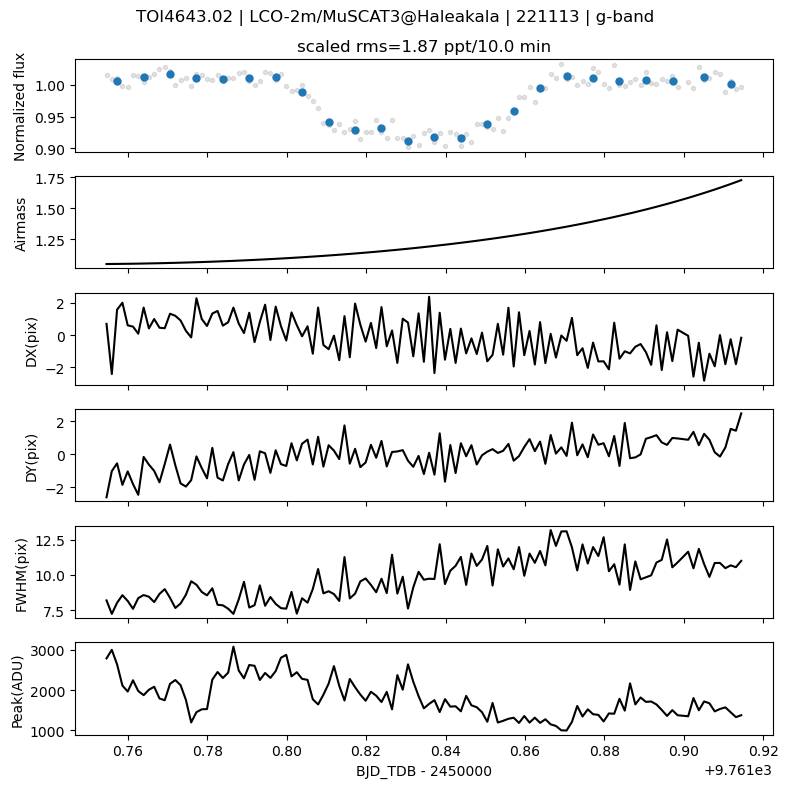

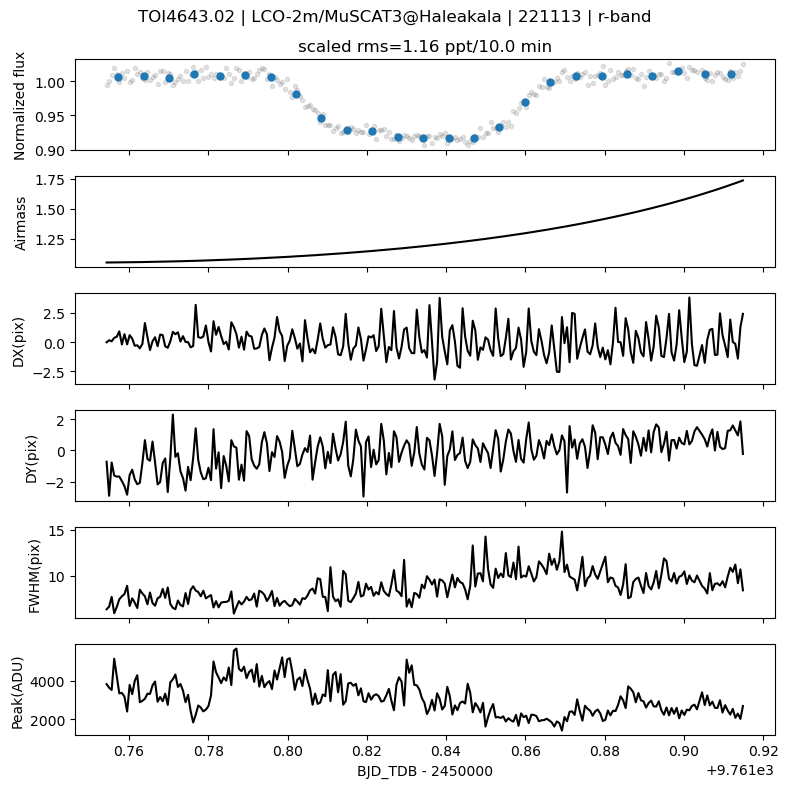

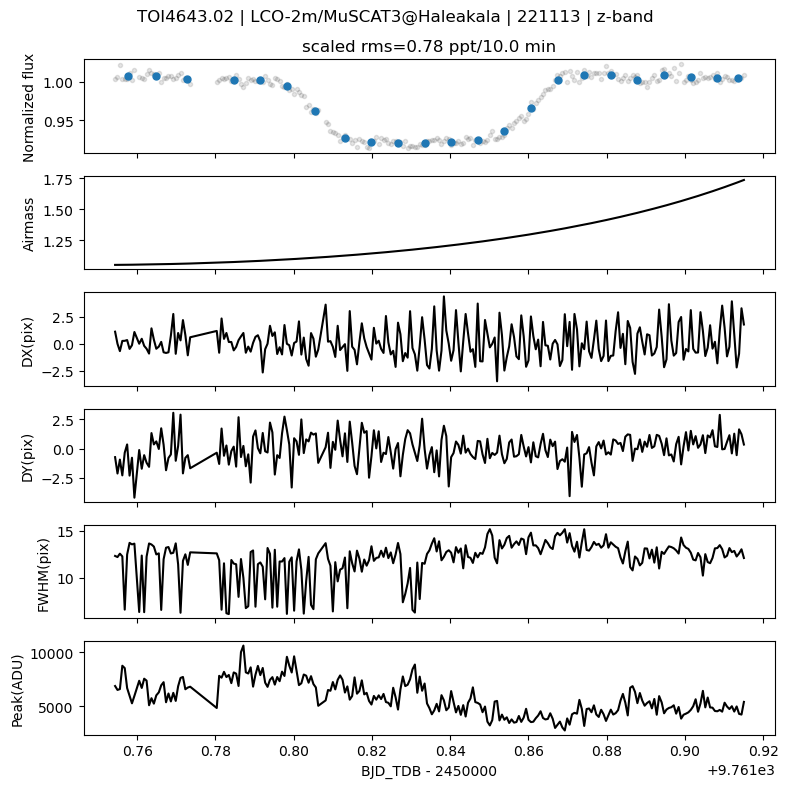

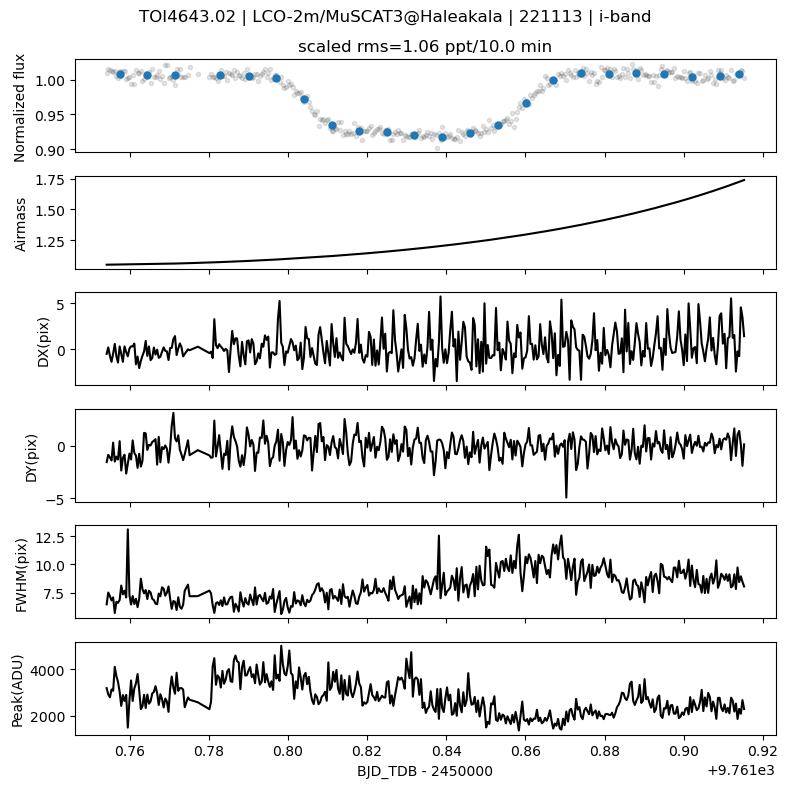

In [64]:
from pathlib import Path
import pandas as pd

photdir = "/raid_ut3/home/muscat/reduction_afphot/notebooks/TFOP/muscat3/TOI5671.01/"
fps = Path(photdir).glob("*.csv")

for fp in fps:
    df = pd.read_csv(fp)
    band = str(fp).split('/')[-1].split('_')[2]
    fig = plot_ql(df,
                  221113,
                target='TOI4643',
                planet='.02',
                  exptime=10,
                band=band,
                site='Haleakala',
                tel='LCO-2m',
                inst='MuSCAT3',
                rms_bintime_mins=10
                 )